In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy
import matplotlib.pyplot as plt

2024-03-13 07:19:05.264601: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 07:19:05.547524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 07:19:05.547555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 07:19:05.596849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 07:19:05.695499: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
data = np.load('/mnt/c/Users/mriga/OneDrive/Documents/PINNs_cavity/Data.npy', allow_pickle=True).item()

In [4]:
data

{'pressure': array([[-0.01413474, -0.01413474, -0.01422708, ...,  0.00540174,
          0.00530651,  0.00530651],
        [-0.01413474, -0.01413474, -0.01422708, ...,  0.00540174,
          0.00530651,  0.00530651],
        [-0.01404263, -0.01404263, -0.01413534, ...,  0.00530665,
          0.0052112 ,  0.0052112 ],
        ...,
        [-0.33231304, -0.33231304, -0.21725116, ...,  0.38687703,
          0.55074888,  0.55074888],
        [-0.83319839, -0.83319839, -0.45552227, ...,  0.72183789,
          1.13464237,  1.13464237],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 'u_velocity': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -7.26015549e-06, -5.38908045e-05, ...,
         -5.93716503e-05, -8.93399088e-06,  0.00000000e+00],
        [ 0.00000000e+00, -5.03177439e-05, -1.73161142e-04, ...,
         -1.83749156e-04, -5.3

In [5]:
## Extracting the pressure, u_velocity, v_velocity, x_points, and y_points

pressure = data['pressure']
u_velocity = data['u_velocity']  
v_velocity = data['v_velocity']  
x_points = data['x']  
y_points = data['y']  

In [6]:
p_flat = pressure.flatten()
u_flat = u_velocity.flatten()
v_flat = v_velocity.flatten()
x_flat = x_points.flatten()
y_flat = y_points.flatten()


coordinates = np.stack((x_flat, y_flat), axis=-1)

border_skip = 3
interior_mask = (x_flat >= x_points[border_skip, border_skip]) & \
                (x_flat <= x_points[-border_skip, -border_skip]) & \
                (y_flat >= y_points[border_skip, border_skip]) & \
                (y_flat <= y_points[-border_skip, -border_skip])


interior_coordinates = coordinates[interior_mask]
interior_p = p_flat[interior_mask]
interior_u = u_flat[interior_mask]
interior_v = v_flat[interior_mask]

num_samples = 100
indices = np.random.choice(interior_coordinates.shape[0], num_samples, replace=False)

In [27]:
sampled_coordinates = interior_coordinates[indices]
sampled_p = interior_p[indices]
sampled_u = interior_u[indices]
sampled_v = interior_v[indices]

In [28]:
num_boundary_points = 61  

## Bottom boundary (no-slip)
x_bottom = np.linspace(0, 1, num_boundary_points)
y_bottom = np.zeros_like(x_bottom)
u_bottom = np.zeros_like(x_bottom)
v_bottom = np.zeros_like(x_bottom)

## Top boundary (driven lid)
x_top = np.linspace(0, 1, num_boundary_points)
y_top = np.ones_like(x_top)
u_top = np.ones_like(x_top)  # Lid driven condition
v_top = np.zeros_like(x_top)

## Left boundary (no-slip)
y_left = np.linspace(0, 1, num_boundary_points)
x_left = np.zeros_like(y_left)
u_left = np.zeros_like(y_left)
v_left = np.zeros_like(y_left)

## Right boundary (no-slip)
y_right = np.linspace(0, 1, num_boundary_points)
x_right = np.ones_like(y_right)
u_right = np.zeros_like(y_right)
v_right = np.zeros_like(y_right)

## Combine x and y boundary coordinates
x_boundary = np.concatenate([x_bottom, x_top, x_left, x_right])
y_boundary = np.concatenate([y_bottom, y_top, y_left, y_right])

## Combine u and v boundary values
u_boundary = np.concatenate([u_bottom, u_top, u_left, u_right])
v_boundary = np.concatenate([v_bottom, v_top, v_left, v_right])

## Neumann boundary condition (gradient = 0)
## Simplification for the PINN, since we cannot directly enforce a gradient condition
p_boundary = np.zeros_like(x_boundary)  

## Converting boundary conditions to tensors
x_boundary_tensor = tf.convert_to_tensor(x_boundary, dtype=tf.float32)
y_boundary_tensor = tf.convert_to_tensor(y_boundary, dtype=tf.float32)
u_boundary_tensor = tf.convert_to_tensor(u_boundary, dtype=tf.float32)
v_boundary_tensor = tf.convert_to_tensor(v_boundary, dtype=tf.float32)
p_boundary_tensor = tf.convert_to_tensor(p_boundary, dtype=tf.float32)

## Bundling the boundary conditions into a tuple to pass to the train_step function
boundary_data = (x_boundary_tensor, y_boundary_tensor, u_boundary_tensor, v_boundary_tensor, p_boundary_tensor)

In [29]:
## Define Reynolds number
Re = 100

In [30]:
class PINN(keras.Model):
    
    def __init__(self, layer_sizes, optimizer=tf.optimizers.Adam(learning_rate=0.001)):
        super(PINN, self).__init__()
        
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(2,))
        self.hidden_layers = [tf.keras.layers.Dense(size, activation=tf.nn.tanh) for size in layer_sizes]
        self.output_layer_u = tf.keras.layers.Dense(1)
        self.output_layer_v = tf.keras.layers.Dense(1)
        self.output_layer_p = tf.keras.layers.Dense(1)
        self.optimizer = optimizer  

    def call(self, inputs, training=False):
        x = self.input_layer(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        u = self.output_layer_u(x)
        v = self.output_layer_v(x)
        p = self.output_layer_p(x)
        return u, v, p
    
    ## Custom training loop
    def train_step(self, data, boundary_data):
        
        x, y, true_u, true_v, true_p = [tf.convert_to_tensor(d, dtype=tf.float32) for d in data]
        x_boundary, y_boundary, u_boundary, v_boundary, p_boundary = [tf.convert_to_tensor(d, dtype=tf.float32) for d in boundary_data]

        ## Creating a mask for the driven lid (where y = 1)
        mask_driven_lid = tf.equal(y_boundary, 1.0)
        
        ## Mask for pressure boundaries
        mask_left = tf.equal(x_boundary, 0.0)
        mask_right = tf.equal(x_boundary, 1.0)
        mask_bottom = tf.equal(y_boundary, 0.0)
        
        ## Mask for no-slip condition (everywhere else)
        mask_no_slip = tf.logical_not(mask_driven_lid)

        with tf.GradientTape(persistent=True) as tape:
            X = tf.stack([x, y], axis=1)
            tape.watch(X)

            ## Interior predictions
            u_pred, v_pred, p_pred = self(X, training=True)  

            ## Boundary predictions
            X_boundary = tf.stack([x_boundary, y_boundary], axis=1)
            tape.watch(X_boundary)
            u_pred_boundary, v_pred_boundary, p_pred_boundary = self(X_boundary, training=True)

            ## Computing gradients for Neumann BC
            grad_p_boundary = tape.gradient(p_pred_boundary, X_boundary)
            p_x_boundary, p_y_boundary = grad_p_boundary[:, 0], grad_p_boundary[:, 1]

            ## Calculating Neumann boundary loss for left, right, and bottom boundaries
            neumann_loss_left = tf.reduce_mean(tf.square(p_x_boundary * tf.cast(mask_left, tf.float32)))
            neumann_loss_right = tf.reduce_mean(tf.square(p_x_boundary * tf.cast(mask_right, tf.float32)))
            neumann_loss_bottom = tf.reduce_mean(tf.square(p_y_boundary * tf.cast(mask_bottom, tf.float32)))

            ## Calculating loss for the no-slip boundary conditions
            no_slip_loss_u = tf.reduce_mean(tf.square(u_pred_boundary - u_boundary) * tf.cast(mask_no_slip, tf.float32))
            no_slip_loss_v = tf.reduce_mean(tf.square(v_pred_boundary - v_boundary) * tf.cast(mask_no_slip, tf.float32))

            ## Calculating loss for the driven lid boundary condition
            driven_lid_loss_u = tf.reduce_mean(tf.square(u_pred_boundary - u_boundary) * tf.cast(mask_driven_lid, tf.float32))
            driven_lid_loss_v = tf.reduce_mean(tf.square(v_pred_boundary - v_boundary) * tf.cast(mask_driven_lid, tf.float32))

            # print('no_slip_loss_u:', no_slip_loss_u)
            # print('no_slip_loss_v:', no_slip_loss_v)
            # print('driven_lid_loss_u:', driven_lid_loss_u)
            # print('driven_lid_loss_v:', driven_lid_loss_v)

            boundary_loss = driven_lid_loss_u + driven_lid_loss_v + neumann_loss_left + neumann_loss_right + neumann_loss_bottom + no_slip_loss_u + no_slip_loss_v

            ## Flatten predictions for easier processing
            u_pred = tf.reshape(u_pred, [-1])
            v_pred = tf.reshape(v_pred, [-1])
            p_pred = tf.reshape(p_pred, [-1])

            ## Calculating first-order gradients
            grad_u = tape.gradient(u_pred, X)
            grad_v = tape.gradient(v_pred, X)
            grad_p = tape.gradient(p_pred, X)

            u_x, u_y = grad_u[:, 0], grad_u[:, 1]
            v_x, v_y = grad_v[:, 0], grad_v[:, 1]
            p_x, p_y = grad_p[:, 0], grad_p[:, 1]

            ## Calculating second-order gradients for diffusion terms
            u_xx = tape.gradient(u_x, X)[:, 0]
            u_yy = tape.gradient(u_y, X)[:, 1]
            v_xx = tape.gradient(v_x, X)[:, 0]
            v_yy = tape.gradient(v_y, X)[:, 1]

            ## Continuity equation residual
            continuity_residual = u_x + v_y

            ## Momentum equation residuals (including diffusion terms)
            u_momentum_residual = u_pred * u_x + v_pred * u_y + p_x - (1 / Re) * (u_xx + u_yy)
            v_momentum_residual = u_pred * v_x + v_pred * v_y + p_y - (1 / Re) * (v_xx + v_yy)

            ## Calculating loss for the data fit
            loss_data_fit = tf.reduce_mean(tf.square(true_u - u_pred)) + tf.reduce_mean(tf.square(true_v - v_pred))

            ## Calculating the residuals' loss
            loss_residual = tf.reduce_mean(tf.square(continuity_residual)) + \
                            tf.reduce_mean(tf.square(u_momentum_residual)) + \
                            tf.reduce_mean(tf.square(v_momentum_residual))
            
            # print('loss_data_fit:', loss_data_fit)
            # print('loss_residual:', loss_residual)

            ## Total loss
            loss = loss_data_fit + loss_residual + boundary_loss
            

        ## Compute gradients of the loss with respect to the model variables
        gradients = tape.gradient(loss, self.trainable_variables)

        ## Applying the gradients to the model's variables
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return  loss


layers_sizes = [50, 100, 100, 100, 50]

initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# optimizer = tf.optimizers.Adam() # learning_rate=0.00001
model = PINN(layer_sizes=layers_sizes, optimizer=optimizer)

In [31]:
## Convert sampled data to float32
sampled_x = np.array(sampled_coordinates[:, 0], dtype=np.float32)
sampled_y = np.array(sampled_coordinates[:, 1], dtype=np.float32)
sampled_u = np.array(sampled_u, dtype=np.float32)
sampled_v = np.array(sampled_v, dtype=np.float32)
sampled_p = np.array(sampled_p, dtype=np.float32)

## Training the model
epochs = 30000  
for epoch in range(epochs):
    loss = model.train_step([sampled_x, sampled_y, sampled_u, sampled_v, sampled_p], boundary_data)
 
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 0.1541684865951538
Epoch 100, Loss: 0.02732011117041111
Epoch 200, Loss: 0.0216054767370224
Epoch 300, Loss: 0.020273225381970406
Epoch 400, Loss: 0.01986650377511978
Epoch 500, Loss: 0.01964920572936535
Epoch 600, Loss: 0.019495753571391106
Epoch 700, Loss: 0.019383851438760757
Epoch 800, Loss: 0.019301630556583405
Epoch 900, Loss: 0.01923961192369461
Epoch 1000, Loss: 0.019190531224012375
Epoch 1100, Loss: 0.01915065571665764
Epoch 1200, Loss: 0.01911458559334278
Epoch 1300, Loss: 0.019080281257629395
Epoch 1400, Loss: 0.01904647797346115
Epoch 1500, Loss: 0.01901242509484291
Epoch 1600, Loss: 0.01897767372429371
Epoch 1700, Loss: 0.01894192583858967
Epoch 1800, Loss: 0.018904922530055046
Epoch 1900, Loss: 0.018866419792175293
Epoch 2000, Loss: 0.018826119601726532
Epoch 2100, Loss: 0.01878535747528076
Epoch 2200, Loss: 0.01874212920665741
Epoch 2300, Loss: 0.01869593933224678
Epoch 2400, Loss: 0.018646176904439926
Epoch 2500, Loss: 0.01859208382666111
Epoch 2600, Loss

PLOTTING

In [12]:
x_min, x_max = 0, 1  
y_min, y_max = 0, 1  
resolution = 61  


x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)
test_points = np.stack([X.flatten(), Y.flatten()], axis=-1)  

In [13]:
test_points_tensor = tf.convert_to_tensor(test_points, dtype=tf.float32)

u_pred, v_pred, p_pred = model(test_points_tensor, training=False)

U_pred = u_pred.numpy().reshape(X.shape)
V_pred = v_pred.numpy().reshape(X.shape)
P_pred = p_pred.numpy().reshape(X.shape)

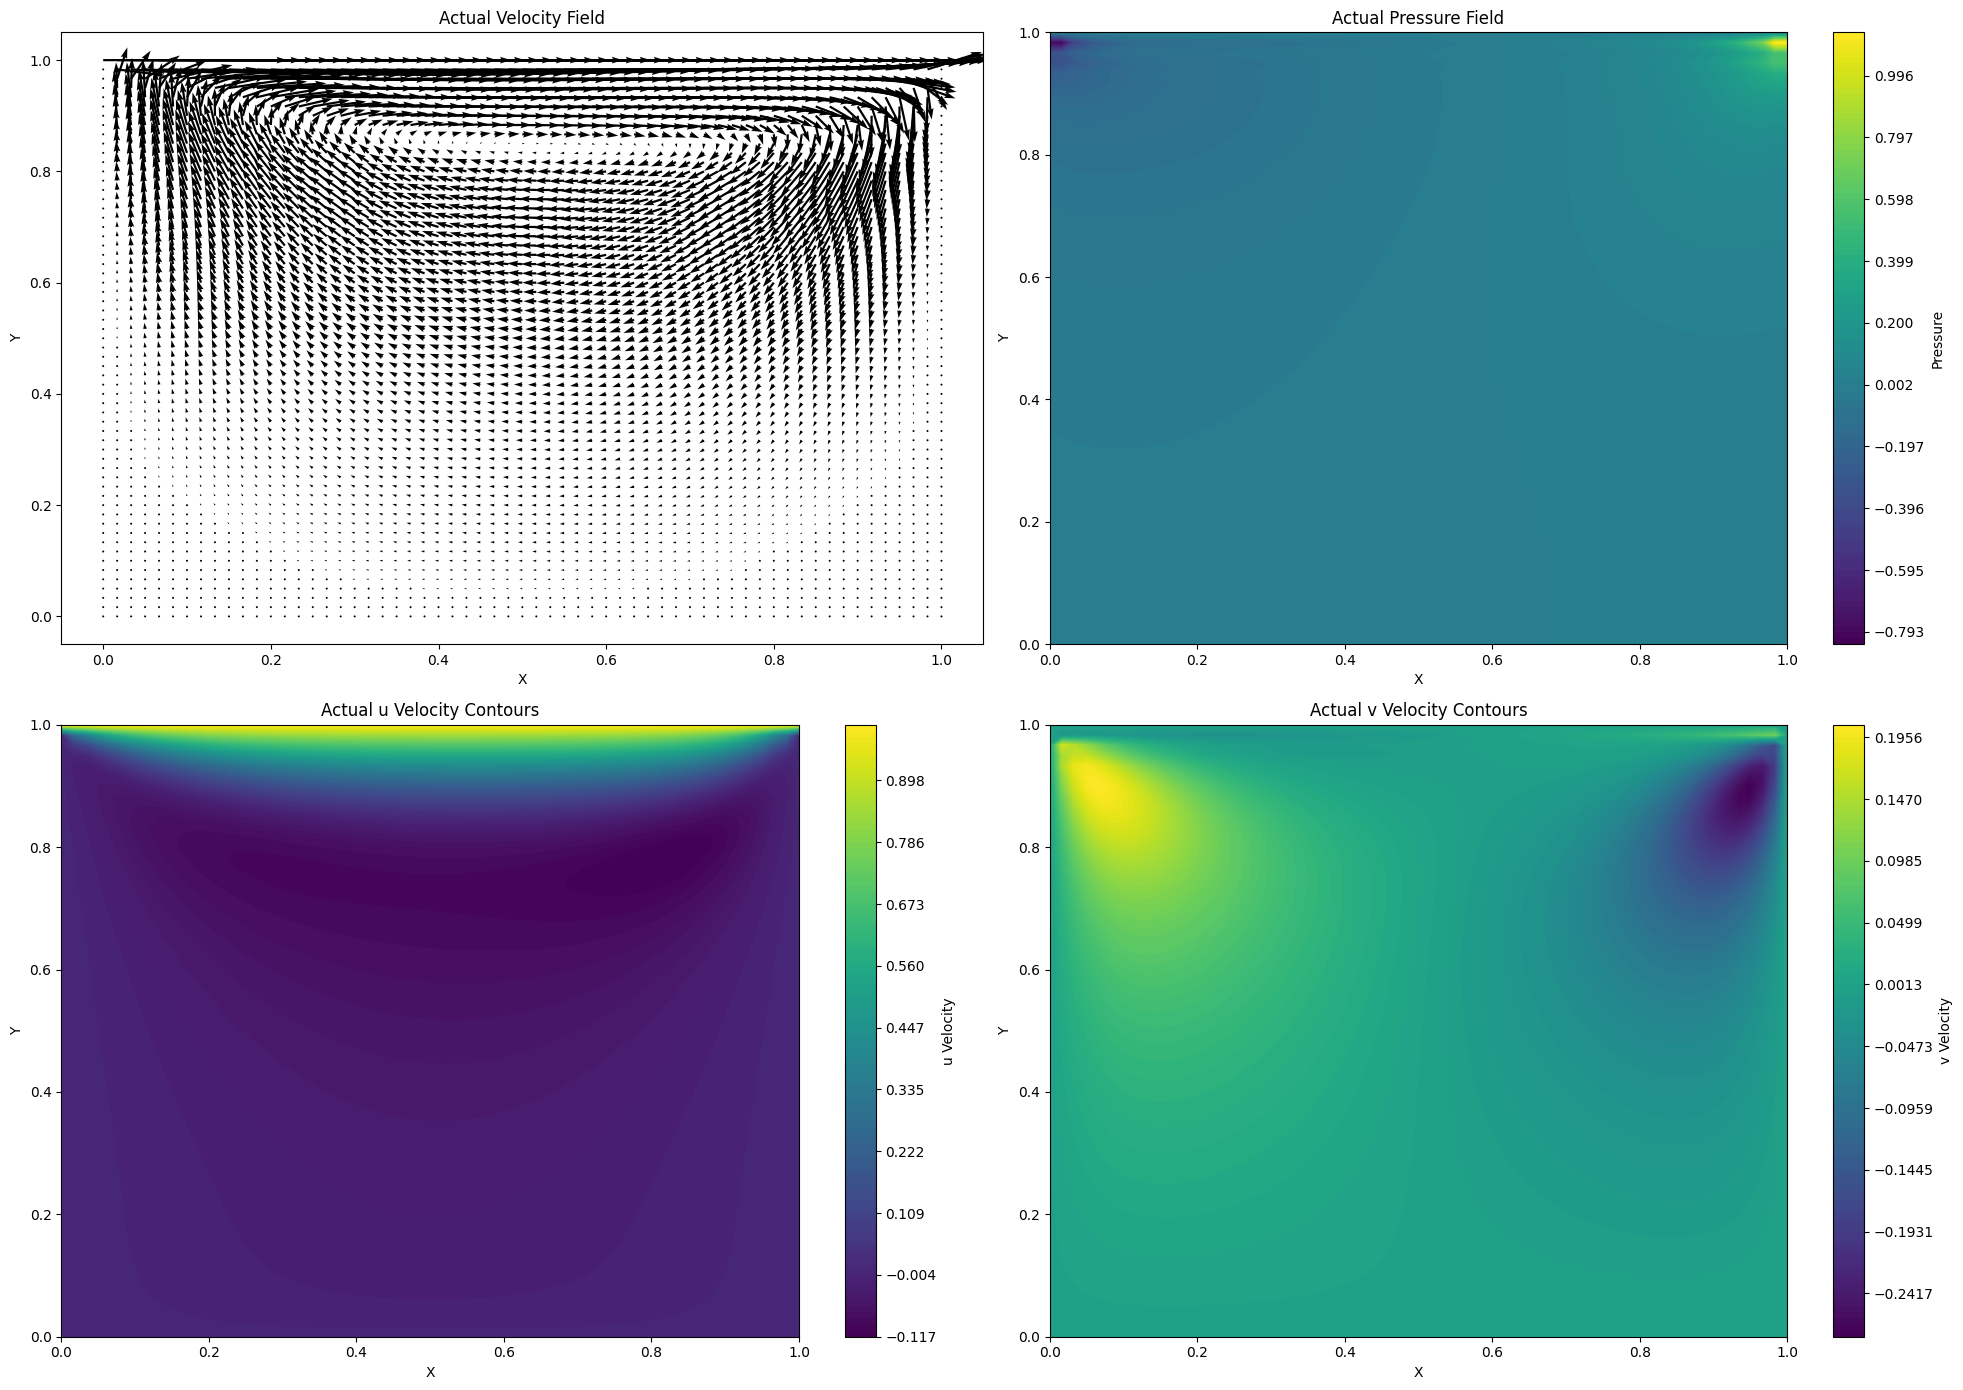

In [26]:
plt.figure(figsize=(20, 14))  


plt.subplot(2, 2, 1)  
plt.quiver(X, Y, u_velocity, v_velocity, scale=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual Velocity Field')


plt.subplot(2, 2, 2)  
contour_levels = np.linspace(pressure.min(), pressure.max(), 100)
plt.contourf(X, Y, pressure, levels=contour_levels, cmap='viridis')
plt.colorbar(label='Pressure')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual Pressure Field')


plt.subplot(2, 2, 3)  
contour_levels_u = np.linspace(u_velocity.min(), u_velocity.max(), 100)
plt.contourf(X, Y, u_velocity, levels=contour_levels_u, cmap='viridis')
plt.colorbar(label='u Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual u Velocity Contours')


plt.subplot(2, 2, 4)  
contour_levels_v = np.linspace(v_velocity.min(), v_velocity.max(), 100)
plt.contourf(X, Y, v_velocity, levels=contour_levels_v, cmap='viridis')
plt.colorbar(label='v Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual v Velocity Contours')

plt.tight_layout()  
plt.show()

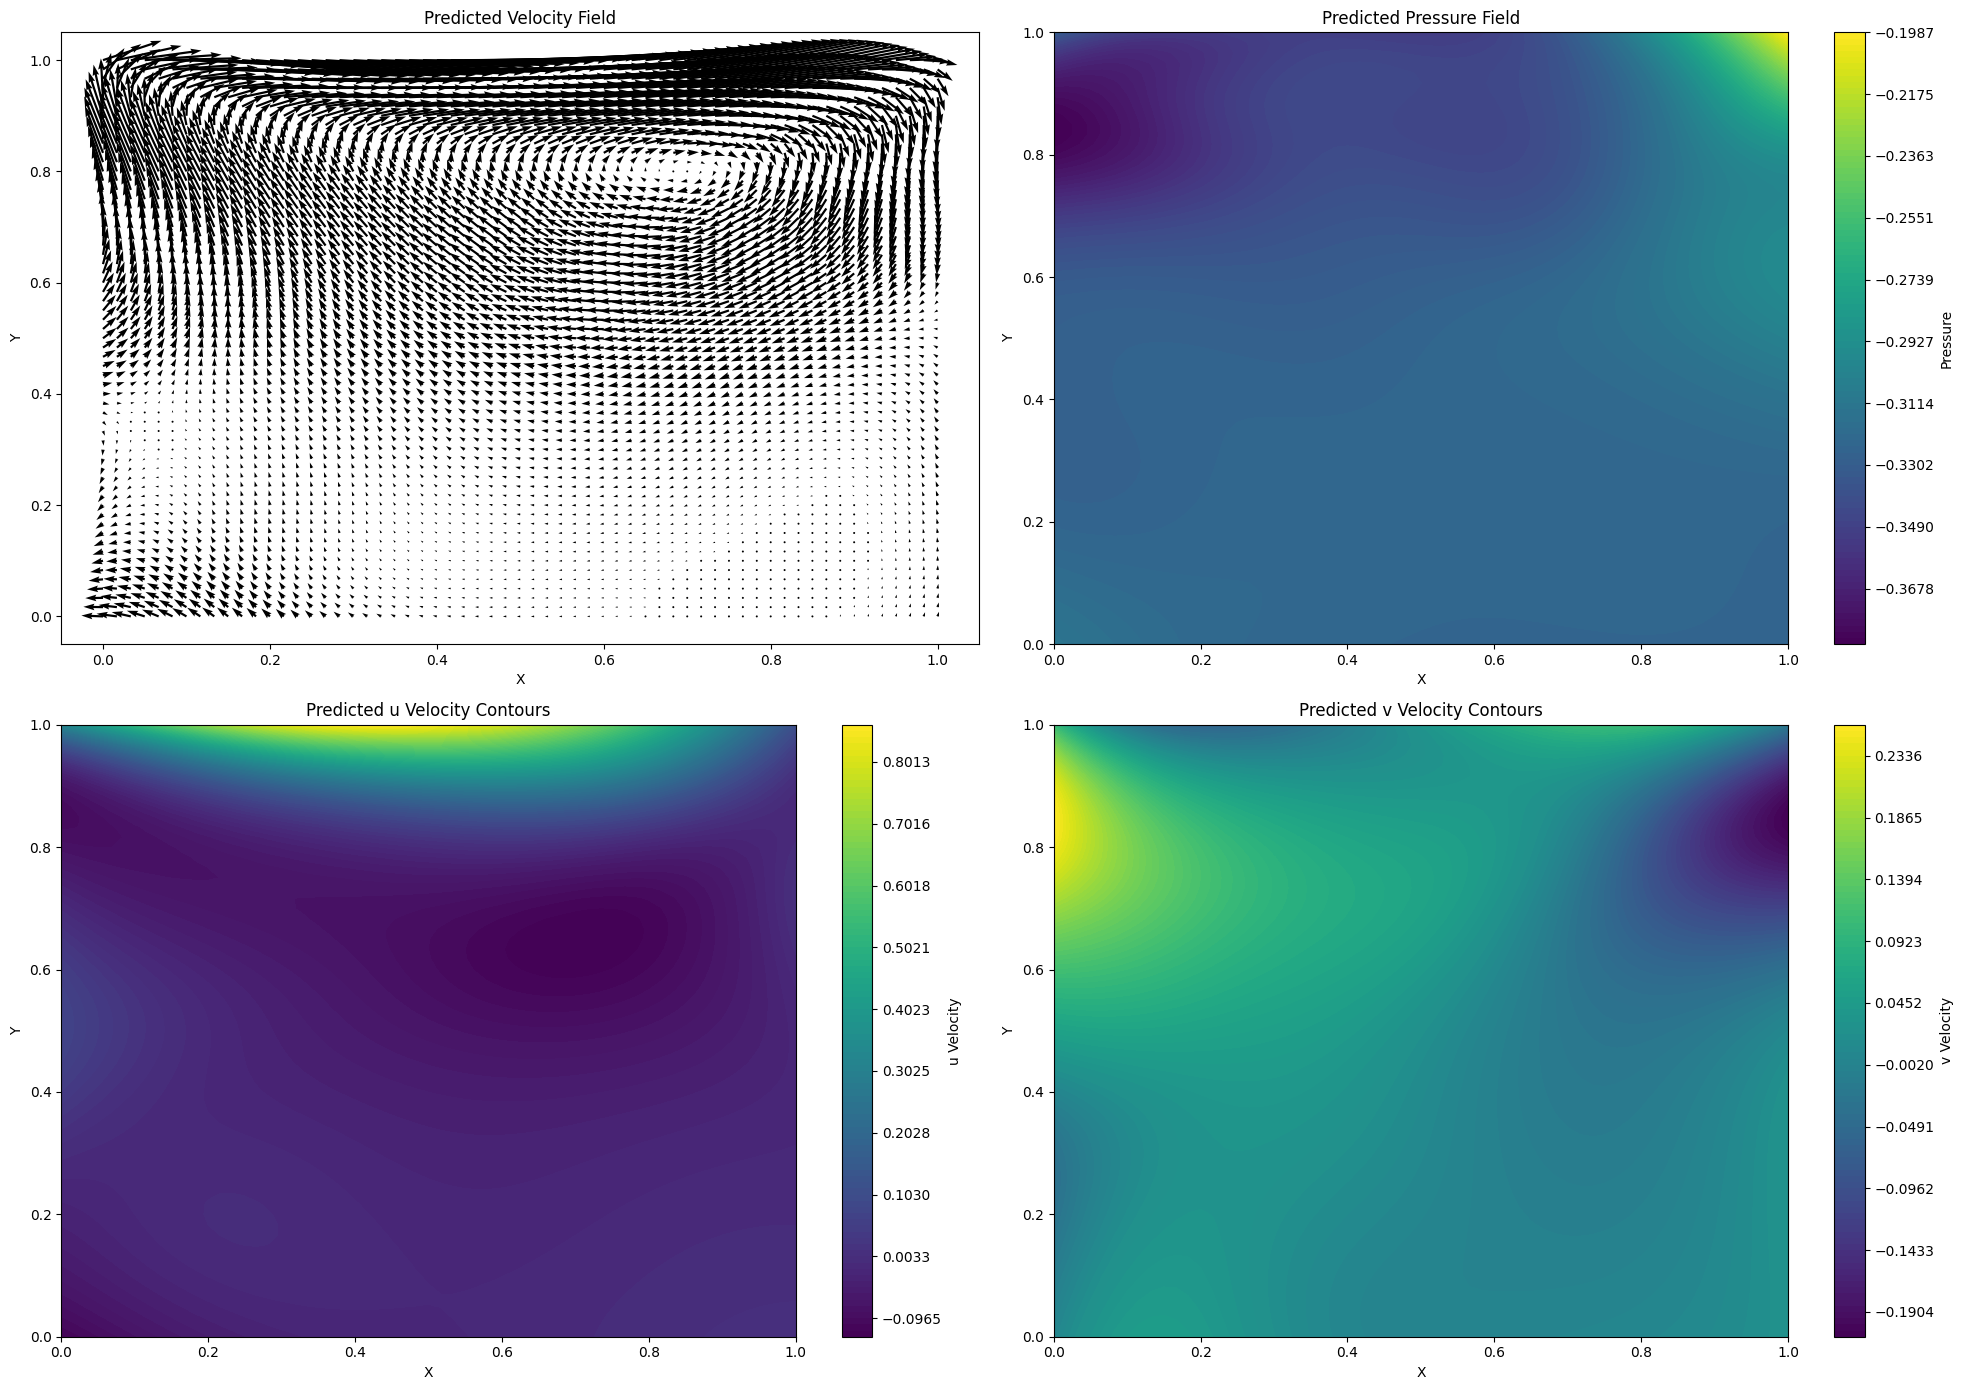

In [25]:
plt.figure(figsize=(20, 14))  


plt.subplot(2, 2, 1)  
plt.quiver(X, Y, U_pred, V_pred, scale=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted Velocity Field')


plt.subplot(2, 2, 2)  
contour_levels = np.linspace(P_pred.min(), P_pred.max(), 100) 
plt.contourf(X, Y, P_pred, levels=contour_levels, cmap='viridis')
plt.colorbar(label='Pressure')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted Pressure Field')


plt.subplot(2, 2, 3)  
contour_levels_u = np.linspace(U_pred.min(), U_pred.max(), 100)  
plt.contourf(X, Y, U_pred, levels=contour_levels_u, cmap='viridis')
plt.colorbar(label='u Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted u Velocity Contours')


plt.subplot(2, 2, 4)  
contour_levels_v = np.linspace(V_pred.min(), V_pred.max(), 100)  
plt.contourf(X, Y, V_pred, levels=contour_levels_v, cmap='viridis')
plt.colorbar(label='v Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted v Velocity Contours')

plt.tight_layout()  
plt.show()